In [1]:
import torch
torch.cuda.empty_cache()

# Import Libraries

In [2]:
import os
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

import matplotlib.pyplot as plt
import random
import copy
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import f1_score, accuracy_score
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
#from efficientnet_pytorch import model as enet

import cv2
import timm

from tqdm import tqdm
from tqdm.notebook import tqdm

import albumentations as A
from albumentations import (
    Compose, OneOf, Normalize, CenterCrop, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, RandomRotate90, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

import logging
import time
from contextlib import contextmanager

# Config

In [3]:
class CFG:
    DATA_PATH = '../input/plant-pathology-2021-fgvc8/'
    TEST_PATH = DATA_PATH + 'test_images/'
    TRAIN_PATH = DATA_PATH + 'train_images/'
    TRAIN_CSV_PATH = DATA_PATH + 'train.csv'
    TEST_CSV_PATH = DATA_PATH + 'sample_submission.csv'
    
    MODEL_ARCH ='efficientnet_b2'
    #MODEL_ARCH = 'efficientnet_b4'
    IMG_SIZE = 256
    EPOCH = 10
    BATCH_SIZE = 32
    DEBUG_SIZE = 0.1
    RANDOM_STATE = 1234
    CLASS_THRESHOLD = 0.4
    DROPOUT = .4
    LR = 5e-4
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LABELS = ['healthy','complex','rust','frog_eye_leaf_spot','powdery_mildew','scab']
    N_CLASS = len(LABELS)
    LABELS_DICT = {
    0: 'healthy', 
    1: 'scab',
    2: 'rust',
    3: 'frog_eye_leaf_spot',
    4: 'complex', 
    5: 'powdery_mildew'}


In [4]:
train_df = pd.read_csv(CFG.TRAIN_CSV_PATH)
sub_df = pd.read_csv(CFG.TEST_CSV_PATH)

In [5]:
print(f'Using {CFG.DEVICE} device.')
torch.rand(10, device=CFG.DEVICE)

Using cuda device.


tensor([0.2475, 0.7763, 0.1012, 0.6894, 0.9818, 0.3023, 0.8232, 0.5314, 0.3772,
        0.2418], device='cuda:0')

# EDA

In [6]:
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [7]:
sub_df

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [8]:
train_df['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [9]:
def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for x, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, x + 1)
        image = cv2.imread(os.path.join(path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

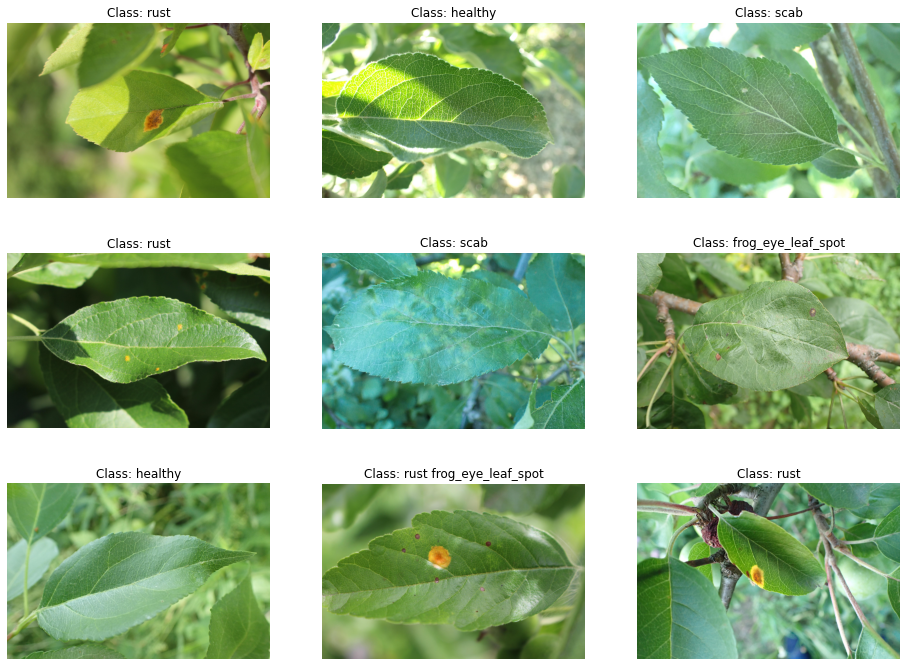

In [10]:
tmp_df = train_df.sample(9)
image_ids = tmp_df["image"].values
labels = tmp_df["labels"].values
visualize_batch(CFG.TRAIN_PATH,image_ids,labels)

In [11]:
train_df['label_list'] = train_df['labels'].str.split(' ')
train_df

,image,labels,label_list
0,800113bb65efe69e.jpg,healthy,[healthy]
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,scab,[scab]
3,80077517781fb94f.jpg,scab,[scab]
4,800cbf0ff87721f8.jpg,complex,[complex]
...,...,...,...
18627,fffb900a92289a33.jpg,healthy,[healthy]
18628,fffc488fa4c0e80c.jpg,scab,[scab]
18629,fffc94e092a59086.jpg,rust,[rust]
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot,"[scab, frog_eye_leaf_spot]"


In [12]:
CFG.LABELS_DICT

{0: 'healthy',
 1: 'scab',
 2: 'rust',
 3: 'frog_eye_leaf_spot',
 4: 'complex',
 5: 'powdery_mildew'}

# One hot encoding

In [13]:
#label listの要素を列名にしてtrain_dfに0を初期値として結合する
#LABELS = ['healthy','complex','rust','frog_eye_leaf_spot','powdery_mildew','scab']
for x in CFG.LABELS:
    train_df[x]=0
train_df

,image,labels,label_list,healthy,complex,rust,frog_eye_leaf_spot,powdery_mildew,scab
0,800113bb65efe69e.jpg,healthy,[healthy],0,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]",0,0,0,0,0,0
2,80070f7fb5e2ccaa.jpg,scab,[scab],0,0,0,0,0,0
3,80077517781fb94f.jpg,scab,[scab],0,0,0,0,0,0
4,800cbf0ff87721f8.jpg,complex,[complex],0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
18627,fffb900a92289a33.jpg,healthy,[healthy],0,0,0,0,0,0
18628,fffc488fa4c0e80c.jpg,scab,[scab],0,0,0,0,0,0
18629,fffc94e092a59086.jpg,rust,[rust],0,0,0,0,0,0
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot,"[scab, frog_eye_leaf_spot]",0,0,0,0,0,0


In [14]:
#ある列がlabel_listと一致するなら1, しないなら0を返す
def onehot(col, label_list):
    if col in label_list:
        t = 1
    else:
        t = 0
    return t

In [15]:
#LABELS = ['healthy','complex','rust','frog_eye_leaf_spot','powdery_mildew','scab']
for x in CFG.LABELS:
    """
    class numpy.vectorize(pyfunc, otypes=None, doc=None, excluded=None, cache=False, signature=None)
    """
    train_df[x] = np.vectorize(onehot)(x,train_df['label_list'])
train_df

,image,labels,label_list,healthy,complex,rust,frog_eye_leaf_spot,powdery_mildew,scab
0,800113bb65efe69e.jpg,healthy,[healthy],1,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]",0,1,0,1,0,1
2,80070f7fb5e2ccaa.jpg,scab,[scab],0,0,0,0,0,1
3,80077517781fb94f.jpg,scab,[scab],0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,complex,[complex],0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
18627,fffb900a92289a33.jpg,healthy,[healthy],1,0,0,0,0,0
18628,fffc488fa4c0e80c.jpg,scab,[scab],0,0,0,0,0,1
18629,fffc94e092a59086.jpg,rust,[rust],0,0,1,0,0,0
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot,"[scab, frog_eye_leaf_spot]",0,0,0,1,0,1


In [16]:
train_df2 = train_df.drop(['labels','label_list'], axis = 1)
train_df2

,image,healthy,complex,rust,frog_eye_leaf_spot,powdery_mildew,scab
0,800113bb65efe69e.jpg,1,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,0,1,0,1,0,1
2,80070f7fb5e2ccaa.jpg,0,0,0,0,0,1
3,80077517781fb94f.jpg,0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,0,1,0,0,0,0
...,...,...,...,...,...,...,...
18627,fffb900a92289a33.jpg,1,0,0,0,0,0
18628,fffc488fa4c0e80c.jpg,0,0,0,0,0,1
18629,fffc94e092a59086.jpg,0,0,1,0,0,0
18630,fffe105cf6808292.jpg,0,0,0,1,0,1


In [17]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

@contextmanager
def timer(name, logger=None, level=logging.DEBUG):
    print_ = print if logger is None else lambda msg: logger.log(level, msg)
    t0 = time.time()
    print_(f'[{name}] start')
    yield
    print_(f'[{name}] done in {time.time() - t0:.0f} s')

In [18]:
def to_numpy(tensor):
    """Auxiliary function to convert tensors into numpy arrays
    """
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


In [19]:
DEBUG = False
if DEBUG:
    train_df2 = train_df2.sample(frac = 0.05).reset_index(drop = True)
    print(train_df2.shape)

# Split data

In [20]:
from sklearn.model_selection import train_test_split
train, valid =  train_test_split(train_df2, test_size = 0.2)
print(train.shape, valid.shape)

(14905, 7) (3727, 7)


# Dataset

All datasets that represent a map from keys to data samples should subclass it. All subclasses should overwrite __getitem__(), supporting fetching a data sample for a given key. Subclasses could also optionally overwrite __len__(), which is expected to return the size of the dataset by many Sampler implementations and the default options of DataLoader.

In [21]:
#pytorchのDatasetクラスを継承したクラスを作成する
class TrainDataset(Dataset):
    def __init__(self, train, transform = None): #初期化
        self.train = train
        self.image_names = train["image"].values
        self.labels = train[CFG.LABELS].values
        self.transform = transform
        
#データの長さを返す関数
    def __len__(self):
        return len(self.train)
    
#indexに対応する画像とラベルを返す関数
    def __getitem__(self, idx):
        image_name = self.image_names[idx] #indexに対応するimageの値
        image_path = CFG.TRAIN_PATH + image_name #indexに対応するデータのパス
        image = cv2.imread(image_path) #画像読み込み
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR→RGB
        #label = self.labels[idx] #indexに対応するラベル
        label = torch.tensor(self.labels[idx]).float()
        if self.transform: #前処理ある場合
            augmented = self.transform(image=image)
            image = augmented['image']
            image.shape
        return image, label

# Transform

In [22]:
def get_transforms(*,data):
    
    if data == 'train':
        return Compose([
            A.Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
            A.RandomResizedCrop(CFG.IMG_SIZE, CFG.IMG_SIZE),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(p=0.5),

            A.Normalize(),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return Compose([
            Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
            Normalize(),
            ToTensorV2(),
        ])

In [23]:
# 上で作成したデータセットクラスを呼び出す
train_dataset = TrainDataset(train, transform = get_transforms(data = 'train'))
# データセットクラスによって取り出されるデータをbatch数でまとめる
train_loader = DataLoader(train_dataset, CFG.BATCH_SIZE, shuffle = True,drop_last = True, num_workers=2)

In [24]:
valid_dataset = TrainDataset(valid, transform = get_transforms(data = 'valid'))
valid_loader = DataLoader(valid_dataset, CFG.BATCH_SIZE, shuffle = False, num_workers=2)

In [25]:
DATALOADERS_DICT = {
    'train': train_loader, 
    'valid': valid_loader}

# Create model

class EffNet(nn.Module):
    
    def __init__(self,out_dim):
        super(EffNet, self).__init__()
        self.enet = enet.EfficientNet.from_name(CFG.MODEL_ARCH)
        nc = self.enet._fc.in_features
        self.enet._fc = nn.Identity()
        self.myfc = nn.Sequential(
            nn.Dropout(CFG.DROPOUT),
            nn.Linear(nc, int(nc / 4)),
            nn.Dropout(CFG.DROPOUT),
            nn.Linear(int(nc / 4), out_dim)
        )
        
    def extract(self, x):
        return self.enet(x)
    
    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x
    
model = EffNet(out_dim = len(CFG.LABELS))
model = model.to(CFG.DEVICE)

In [26]:
class EfficientNetB2(nn.Module):
    """
        Base class for all neural network modules.
        Your models should also subclass this class.
        Modules can also contain other Modules, allowing to nest them in a tree structure.
        You can assign the submodules as regular attributes:
    """
    def __init__(self):
        super(EfficientNetB2, self).__init__()
        self.efficientnetb2 = timm.create_model(model_name = CFG.MODEL_ARCH,pretrained = False)
        in_features = self.efficientnetb2.classifier.in_features
        self.efficientnetb2.classifier = nn.Linear(in_features, len(CFG.LABELS))#(input_size,output_size)
        
    def forward(self, x):
        x = self.efficientnetb2(x)
        return x
    
model = EfficientNetB2()
model = model.to(CFG.DEVICE)

#print(in_features)

# Metrics

In [27]:
class MetricMonitor:
    def __init__(self):
        self.reset()

    def reset(self):
        self.losses = []
        self.accuracies = []
        self.scores = []
        self.metrics = dict({
            'loss': self.losses,
            'acc': self.accuracies,
            'f1': self.scores
        })

    def update(self, metric_name, value):
        self.metrics[metric_name] += [value]

In [28]:
from sklearn.metrics import f1_score, accuracy_score

def get_metrics(
    y_pred_proba, 
    y_test, 
    threshold=CFG.CLASS_THRESHOLD,
    labels=CFG.LABELS) -> None:
    """
    """
    y_pred = np.where(y_pred_proba > threshold, 1, 0)

    y1 = y_pred.round().astype(np.float)
    y2 = y_test.round().astype(np.float)
    
    f1 = f1_score(y1, y2, average='micro')
    acc = accuracy_score(y1, y2, normalize=True)

    return acc, f1

# Training

In [29]:
criterion = nn.BCEWithLogitsLoss().to(CFG.DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LR)

def training_loop(
    dataloader, 
    model, 
    criterion, 
    optimizer, 
    epoch, 
    monitor = MetricMonitor(), 
    train=True
):
    """
    """
    size = len(dataloader.dataset)
    
    loss_val = 0
    accuracy = 0
    f1score = 0
    
    if train:
        model.train()
    else:
        model.eval()
    
    stream = tqdm(dataloader)
    for batch, (X, y) in enumerate(stream, start=1):
        X = X.to(CFG.DEVICE)
        y = y.to(CFG.DEVICE)
        
        # compute prediction and loss
        pred_prob = model(X)
        loss = criterion(pred_prob, y)
    
        if train:
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        
        loss_val += loss.item()
        acc, f1 = get_metrics(to_numpy(pred_prob), to_numpy(y))
        
        accuracy += acc 
        f1score += f1

        phase = 'Train' if train else 'Val'
        stream.set_description(
            f'Epoch {epoch:3d}/{CFG.EPOCH} - {phase} - Loss: {loss_val/batch:.4f}, ' + 
            f'Acc: {accuracy/batch:.4f}, F1: {f1score/batch:.4f}'
        )

    monitor.update('loss', loss_val/batch)
    monitor.update('acc', accuracy/batch)
    monitor.update('f1', f1score/batch)
    
model_path = 'model.pth'
torch.save(model.state_dict(), model_path)

In [30]:
train_monitor = MetricMonitor()
test_monitor = MetricMonitor()

In [31]:
for epoch in range(1, CFG.EPOCH + 1):
    # training loop
    training_loop(
        train_loader, 
        model, 
        criterion, 
        optimizer, 
        epoch, 
        train_monitor,
        train=True
    )
    
    # validation loop
    training_loop(
        valid_loader, 
        model, 
        criterion, 
        optimizer, 
        epoch, 
        test_monitor,
        train=False
    )

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

In [32]:
model_path = 'model_x.pt'
torch.save(model.state_dict(), model_path)

In [33]:
from matplotlib.ticker import MaxNLocator 

def plot_result(
    train_losses, 
    test_losses, 
    train_accuracies, 
    test_accuracies, 
    train_scores,
    test_scores
) -> None:
    
    epochs = range(1, len(train_losses) + 1)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))
    
    # plot loss values
    ax[0].plot(epochs, train_losses, label='Training loss', marker ='o')
    ax[0].plot(epochs, test_losses, label='Validation loss', marker ='o')
    ax[0].legend(frameon=False, fontsize=14)
    
    ax[0].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[0].set_title('Loss', fontsize=18)
    ax[0].set_xlabel('Epoch', fontsize=14) 
    ax[0].set_ylabel('Loss', fontsize=14)  
    
    # plot accuracies 
    ax[1].plot(epochs, train_accuracies, label='Training Accuracy', marker ='o')
    ax[1].plot(epochs, test_accuracies, label='Validation accuracy', marker ='o')
    ax[1].legend(frameon=False, fontsize=14)
    
    ax[1].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[1].set_title('Accuracy', fontsize=18)
    ax[1].set_xlabel('Epoch', fontsize=14) 
    ax[1].set_ylabel('Accuracy', fontsize=14)
    
    ax[2].plot(epochs, train_scores, label='Training F1-Score', marker ='o')
    ax[2].plot(epochs, test_scores, label='Validation F1-Score', marker ='o')
    ax[2].legend(frameon=False, fontsize=14)
    
    ax[2].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[2].set_title('F1-Score', fontsize=18)
    ax[2].set_xlabel('Epoch', fontsize=14) 
    ax[2].set_ylabel('F1-Score', fontsize=14) 
        
    plt.show()

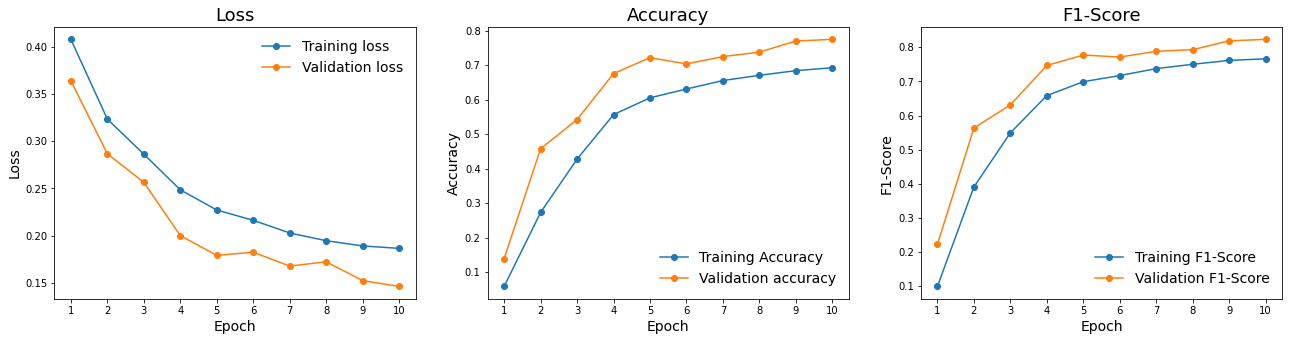

In [34]:
plot_result(
    train_monitor.losses, 
    test_monitor.losses,
    train_monitor.accuracies, 
    test_monitor.accuracies, 
    train_monitor.scores,
    test_monitor.scores
)    